###### Imports

In [3]:
import datetime as dt
import numpy as np
import pandas as pd
import torch
from typing import Text, Union, List
from scipy import optimize 
from scipy import special
from sklearn.preprocessing import StandardScaler
# from core.ml.recurrent import temporalBlockQuantGan
import statsmodels.api as sm
from scipy.stats import kurtosis, norm, rankdata, boxcox
import sklearn
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

###### Data

In [60]:
# from core.utils.dataloader import bloombergDataLoader
# dl = bloombergDataLoader()
# start = dt.date(2011, 1, 1)
# end = dt.date.today()

# data = dl.getData('EURUSD Curncy', 'd', start, end)
# data.to_csv('../data/eurusd.csv')

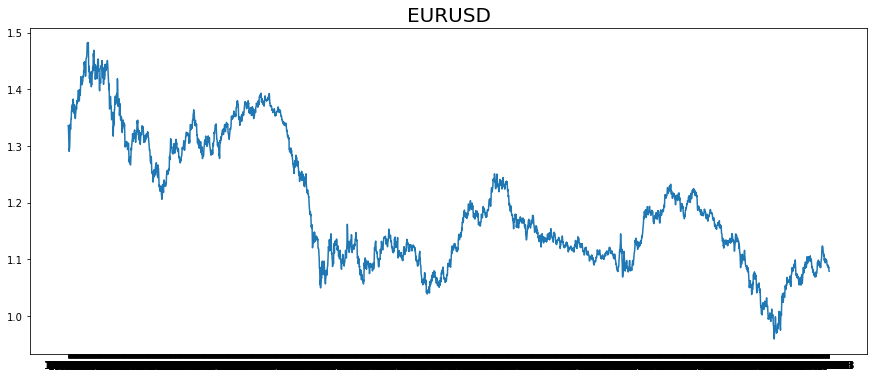

In [4]:
fname = 'eurusd'
data = pd.read_csv(f'../data/{fname}.csv').set_index('date')

fig = plt.figure(figsize=(15,6))
plt.title(f'EURUSD', fontsize=20)
plt.plot(data.index, data['CLOSE'] )
plt.show()

In [5]:
def rolling_window(x, k, sparse=True):
    """compute rolling windows from timeseries

    Args:
        x ([2d array]): x contains the time series in the shape (timestep, sample).
        k ([int]): window length.
        sparse (bool): Cut off the final windows containing NA. Defaults to True.

    Returns:
        [3d array]: array of rolling windows in the shape (window, timestep, sample).
    """    
    out = np.full([k, *x.shape], np.nan)
    N = len(x)
    for i in range(k):
        out[i, :N-i] = x[i:]
            
    if not sparse:
        return out

    return out[:, :-(k-1)]

def acf(x, k, le=False):

    
    arr = rolling_window(x, k, sparse=False)
    a = (arr[0] - np.nanmean(arr[0]))
    if le:
        arr **=2
    b = (arr - np.nanmean(arr, axis=1, keepdims=True))

    return np.nansum((a * b), axis=1) / np.sqrt(np.nansum(a**2, axis=0) * np.nansum(b**2, axis=1))

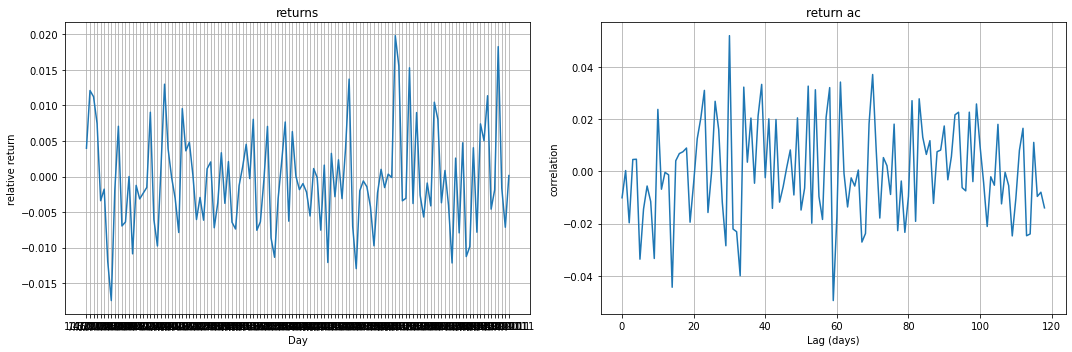

In [6]:
df = data['CLOSE']
returns = df.shift(1)/df - 1
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

#axs[0].plot(returns[:50])
axs[0].plot(returns[1:121])
axs[0].set_title('returns')
axs[1].plot(acf(returns, 120)[1:])
# axs[1].plot(sm.tsa.acf(returns.dropna(), nlags = 119, missing='conservative')[1:])
axs[1].set_title('return ac')

for ax in axs: ax.grid(True)
plt.setp(axs[0], xlabel='Day')
plt.setp(axs[1], xlabel='Lag (days)')
plt.setp(axs[0], ylabel='relative return')
plt.setp(axs[1], ylabel='autocorrelation')
axs[1].set_ylabel('correlation')
plt.tight_layout()

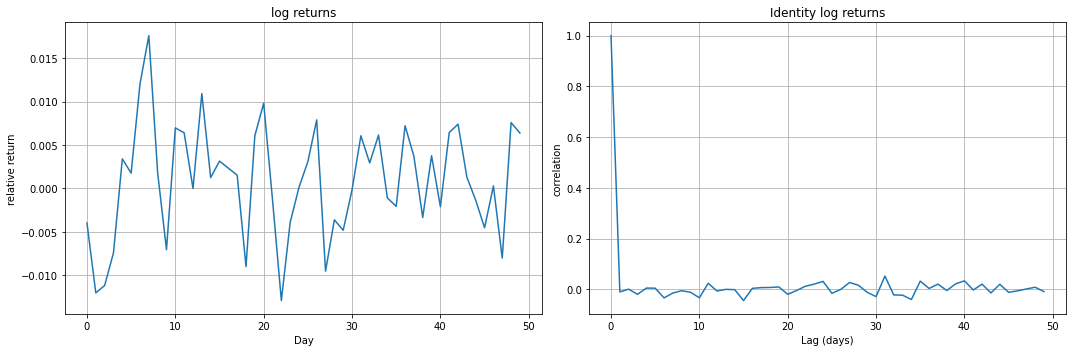

In [7]:
log_returns = np.log(df / df.shift(1))[1:].to_numpy().reshape(-1, 1)
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

#axs[0].plot(returns[:50])
axs[0].plot(log_returns[0:50])
axs[0].set_title('log returns')
axs[1].plot(acf(log_returns, 50))
# axs[1].plot(sm.tsa.acf(returns.dropna(), nlags = 49, missing='conservative'))
axs[1].set_title('Identity log returns')

for ax in axs: ax.grid(True)
plt.setp(axs[0], xlabel='Day')
plt.setp(axs[1], xlabel='Lag (days)')
plt.setp(axs[0], ylabel='relative return')
plt.setp(axs[1], ylabel='autocorrelation')
axs[1].set_ylabel('correlation')
plt.tight_layout()

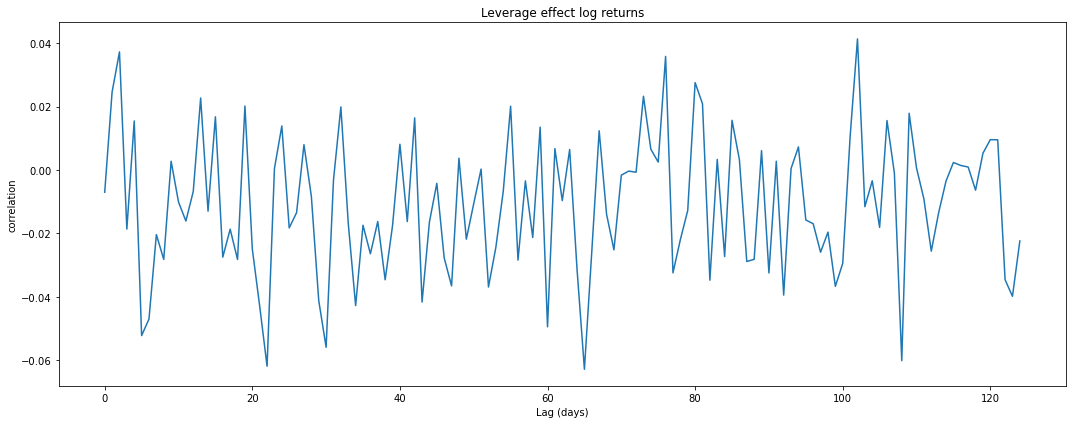

In [8]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(acf(log_returns, 125, le=True))
ax.set_title('Leverage effect log returns')
plt.setp(ax, xlabel='Lag (days)')
plt.setp(ax, ylabel='autocorrelation')
ax.set_ylabel('correlation')
plt.tight_layout()

In [9]:
class Gaussianize(sklearn.base.TransformerMixin):
    """
    Gaussianize data using various methods.

    Conventions
    ----------
    This class is a wrapper that follows sklearn naming/style (e.g. fit(X) to train).
    In this code, x is the input, y is the output. But in the functions outside the class, I follow
    Georg's convention that Y is the input and X is the output (Gaussianized) data.

    Parameters
    ----------
    
    strategy : str, default='lambert'. Possibilities are 'lambert'[1], 'brute'[2] and 'boxcox'[3].

    tol : float, default = 1e-4

    max_iter : int, default = 100
        Maximum number of iterations to search for correct parameters of Lambert transform.

    Attributes
    ----------
    coefs_ : list of tuples
        For each variable, we have transformation parameters.
        For Lambert, e.g., a tuple consisting of (mu, sigma, delta), corresponding to the parameters of the
        appropriate Lambert transform. Eq. 6 and 8 in the paper below.

    References
    ----------
    [1] Georg M Goerg. The Lambert Way to Gaussianize heavy tailed data with
                        the inverse of Tukey's h transformation as a special case
        Author generously provides code in R: https://cran.r-project.org/web/packages/LambertW/
    [2] Valero Laparra, Gustavo Camps-Valls, and Jesus Malo. Iterative Gaussianization: From ICA to Random Rotations
    [3] Box cox transformation and references: https://en.wikipedia.org/wiki/Power_transform
    """
    
    _EPS = 1e-6

    def __init__(self, strategy: Text = 'lambert', 
                 tol: float = 1e-5, 
                 max_iter: int = 100, 
                 verbose: bool = False):
        self.tol = tol
        self.max_iter = max_iter
        self.strategy = strategy
        self.coefs_ = []  # Store tau for each transformed variable
        self.verbose = verbose
        
    @staticmethod
    def _update_x(x: Union[np.ndarray, List]) -> np.ndarray:
        x = np.asarray(x)
        if len(x.shape) == 1:
            x = x[:, np.newaxis]
        elif len(x.shape) != 2:
            raise ValueError("Data should be a 1-d list of samples to transform or a 2d array with samples as rows.")
        return x
    
    @staticmethod
    def w_d(z, delta):
        # Eq. 9
        if delta < Gaussianize._EPS:
            return z
        return np.sign(z) * np.sqrt(np.real(special.lambertw(delta * z ** 2)) / delta)

    @staticmethod
    def w_t(y, tau):
        # Eq. 8
        return tau[0] + tau[1] * Gaussianize.w_d((y - tau[0]) / tau[1], tau[2])

    @staticmethod
    def delta_init(z):
        gamma = kurtosis(z, fisher=False, bias=False)
        with np.errstate(all='ignore'):
            delta0 = np.clip(1. / 66 * (np.sqrt(66 * gamma - 162.) - 6.), 0.01, 0.48)
        if not np.isfinite(delta0):
            delta0 = 0.01
        return delta0
    
    @staticmethod
    def delta_gmm(z):
        # Alg. 1, Appendix C
        delta0 = Gaussianize.delta_init(z)

        def func(q):
            u = Gaussianize.w_d(z, np.exp(q))
            if not np.all(np.isfinite(u)):
                return 0.
            else:
                k = kurtosis(u, fisher=True, bias=False)**2
                if not np.isfinite(k) or k > 1e10:
                    return 1e10
                else:
                    return k

        res = optimize.fmin(func, np.log(delta0), disp=0)
        return np.around(np.exp(res[-1]), 6)

    @staticmethod
    def inverse(x, tau):
        # inverse lambert transform
        # Eq. 6
        u = (x - tau[0]) / tau[1]
        return tau[0] + tau[1] * (u * np.exp(u * u * (tau[2] * 0.5)))
    
    @staticmethod
    def igmm(y: np.ndarray, tol: float = 1e-6, max_iter: int = 100):
        
        
        # Infer mu, sigma, delta using IGMM in Alg.2, Appendix C
        if np.std(y) < Gaussianize._EPS:
            return np.mean(y), np.std(y).clip(Gaussianize._EPS), 0
        delta0 = Gaussianize.delta_init(y)
        tau1 = (np.median(y), np.std(y) * (1. - 2. * delta0) ** 0.75, delta0)
        for k in range(max_iter):
            tau0 = tau1
            z = (y - tau1[0]) / tau1[1]
            delta1 = Gaussianize.delta_gmm(z)
            x = tau0[0] + tau1[1] * Gaussianize.w_d(z, delta1)
            mu1, sigma1 = np.mean(x), np.std(x)
            tau1 = (mu1, sigma1, delta1)

            if np.linalg.norm(np.array(tau1) - np.array(tau0)) < tol:
                break
            else:
                if k == max_iter - 1:
                    warnings.warn("Warning: No convergence after %d iterations. Increase max_iter." % max_iter)
        return tau1
        
    def fit(self, x: np.ndarray, y=None):
        """Fit a Gaussianizing transformation to each variable/column in x."""
        # Initialize coefficients again with an empty list.  Otherwise
        # calling .fit() repeatedly will augment previous .coefs_ list.
        self.coefs_ = []
        x = self._update_x(x)
        if self.verbose:
            print("Gaussianizing with strategy='%s'" % self.strategy)
        
        if self.strategy == "lambert":
            _get_coef = lambda vec: self.igmm(vec, self.tol, max_iter=self.max_iter)
        elif self.strategy == "brute":
            _get_coef = lambda vec: None   # TODO: In principle, we could store parameters to do a quasi-invert
        elif self.strategy == "boxcox":
            _get_coef = lambda vec: boxcox(vec)[1]
        else:
            raise NotImplementedError("stategy='%s' not implemented." % self.strategy)

        for x_i in x.T:
            self.coefs_.append(_get_coef(x_i))

        return self

    def transform(self, x: np.ndarray) -> np.ndarray:
        """Transform new data using a previously learned Gaussianization model."""
        x = self._update_x(x)
        if x.shape[1] != len(self.coefs_):
            raise ValueError("%d variables in test data, but %d variables were in training data." % (x.shape[1], len(self.coefs_)))

        if self.strategy == 'lambert':
            return np.array([Gaussianize.w_t(x_i, tau_i) for x_i, tau_i in zip(x.T, self.coefs_)]).T
        elif self.strategy == 'brute':
            return np.array([norm.ppf((rankdata(x_i) - 0.5) / len(x_i)) for x_i in x.T]).T
        elif self.strategy == 'boxcox':
            return np.array([boxcox(x_i, lmbda=lmbda_i) for x_i, lmbda_i in zip(x.T, self.coefs_)]).T
        else:
            raise NotImplementedError("stategy='%s' not implemented." % self.strategy)

    def inverse_transform(self, y: np.ndarray) -> np.ndarray:
        """Recover original data from Gaussianized data."""
        if self.strategy == 'lambert':
            return np.array([self.inverse(y_i, tau_i) for y_i, tau_i in zip(y.T, self.coefs_)]).T
        elif self.strategy == 'boxcox':
            return np.array([(1. + lmbda_i * y_i) ** (1./lmbda_i) for y_i, lmbda_i in zip(y.T, self.coefs_)]).T
        else:
            raise NotImplementedError("Inversion not supported for gaussianization transform '%s'" % self.strategy)

    def qqplot(self, x: np.ndarray, prefix: Text = 'qq', output_dir: Text = "/tmp/"):
        """Show qq plots compared to normal before and after the transform."""
        x = self._update_x(x)
        y = self.transform(x)
        n_dim = y.shape[1]
        for i in range(n_dim):
            stats.probplot(x[:, i], dist="norm", plot=plt)
            plt.savefig(os.path.join(output_dir, prefix + '_%d_before.png' % i))
            plt.clf()
            stats.probplot(y[:, i], dist="norm", plot=plt)
            plt.savefig(os.path.join(output_dir, prefix + '_%d_after.png' % i))
            plt.clf()            

In [10]:
standardScaler1 = StandardScaler()
standardScaler2 = StandardScaler()
gaussianize = Gaussianize()
log_returns_preprocessed = standardScaler2.fit_transform(gaussianize.fit_transform(standardScaler1.fit_transform(log_returns)))

In [11]:
# Receptive Field Size 127 from paper
log_returns_rolled = rolling_window(log_returns_preprocessed, 127)

(-4.0, 4.0)

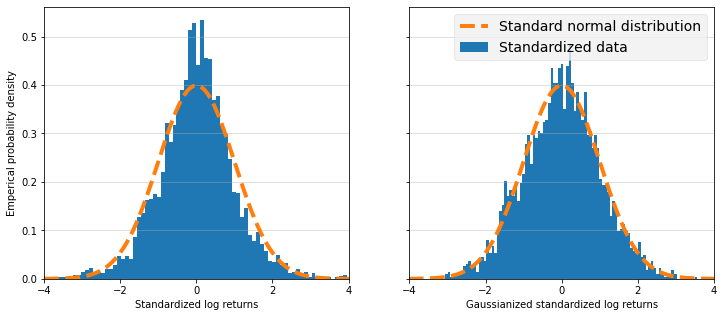

In [12]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5), sharey=True, sharex=True)
# Log returns before and after the lambert W inverse transform respectively (both standardized). 
plt.style.use('fivethirtyeight')

ax[0].hist(standardScaler1.transform(log_returns), bins=100, density=True)
x_range = np.linspace(*ax[0].get_xlim(), num=1000)
ax[0].plot(x_range, norm.pdf(x_range), linestyle='dashed')

ax[1].hist(log_returns_preprocessed, bins=100, density=True)
x_range = np.linspace(*ax[1].get_xlim(), num=1000)
ax[1].plot(x_range, norm.pdf(x_range), linestyle='dashed')

# add a grid to compare easily
ax[0].yaxis.grid(True, alpha=0.5)
ax[1].yaxis.grid(True, alpha=0.5);

ax[1].legend(['Standard normal distribution', 'Standardized data'])
ax[0].set_ylabel('Emperical probability density')
ax[0].set_xlabel('Standardized log returns')
ax[1].set_xlabel('Gaussianized standardized log returns')

ax[0].set_xlim(-4, 4)

In [13]:
class Loader32(torch.utils.data.Dataset):
    
    def __init__(self, data, length):
        assert len(data) >= length
        self.data = data
        self.length = length
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx:idx+self.length]).reshape(-1, self.length).to(torch.float32)
        
    def __len__(self):
        return max(len(self.data)-self.length, 0)

returns = df.shift(1)/df - 1
log_returns = np.log(df/df.shift(1))[1:].to_numpy().reshape(-1, 1)
standardScaler1 = StandardScaler()
standardScaler2 = StandardScaler()
gaussianize = Gaussianize()
log_returns_preprocessed = standardScaler2.fit_transform(gaussianize.fit_transform(standardScaler1.fit_transform(log_returns)))
receptive_field_size = 127  # p. 17
data_size = log_returns.shape[0]
print(log_returns_preprocessed.shape)
print(data_size)

(3299, 1)
3299


###### Model

In [14]:
#################################
#               TCN             #
#################################
class chomp1d(torch.nn.Module):
    def __init__(self, chomp_size):
        super(chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class temporalBlock(torch.nn.Module):
    """
    For implementation of TCNs as described in "An Empirical Evaluation
    of Generic Convolutional and Recurrent Networks for Sequence Modeling"
    by Bai, Koleter and Koltun, 2018.

    While TCNs can be taken to mean 1d convolution with dilations, here
    they describe a "Temporal Block" that is stacked to build a TCN.
    """

    def __init__(self, nin, nout, kernelSize, strides=1, dilation=1, dropout=0.2):
        # Torch assumes input to a conv layer has shape batch x channels x steps
        # When padding <> 0 it pads both the beginning and the end. Therefore, for
        # causal padding need to remove the values at the end with the chomp layer

        super(temporalBlock, self).__init__()

        self.n_in = nin
        self.n_out = nout
        self.kernelSize = kernelSize
        self.strides = strides
        self.dilation = dilation
        self.dropout = dropout
        self.padding = (kernelSize - 1) * dilation

        self.conv1 = torch.nn.Conv1d(in_channels=nin, out_channels=nout, kernel_size=kernelSize,
                                     stride=strides, padding=self.padding, dilation=dilation,
                                     bias=True, padding_mode='zeros')
        self.conv1 = torch.nn.utils.weight_norm(self.conv1)
        self.drop1 = torch.nn.Dropout(p=dropout)

        self.conv2 = torch.nn.Conv1d(in_channels=nout, out_channels=nout, kernel_size=kernelSize,
                                     stride=strides, padding=self.padding, dilation=dilation,
                                     bias=True, padding_mode='zeros')
        self.conv2 = torch.nn.utils.weight_norm(self.conv2)
        self.drop2 = torch.nn.Dropout(p=dropout)

        if self.padding == 0:
            self.net = torch.nn.Sequential(self.conv1,
                                           torch.nn.ReLU(),
                                           self.drop1,
                                           self.conv2,
                                           torch.nn.ReLU(),
                                           self.drop2)
        else:
            self.net = torch.nn.Sequential(self.conv1,
                                           chomp1d(self.padding),
                                           torch.nn.ReLU(),
                                           self.drop1,
                                           self.conv2,
                                           chomp1d(self.padding),
                                           torch.nn.ReLU(),
                                           self.drop2)

        if nin != nout:
            # we will need a linear layer for the skip connection
            self.conv3 = torch.nn.Conv1d(in_channels=nin, out_channels=nout,
                                         kernel_size=1, bias=True)
        else:
            self.conv3 = None

    def forward(self, inputs):
        x = self.net(inputs)
        res = inputs if self.conv3 is None else self.conv3(inputs)
        return x + res  # skip connection!


class temporalConvolutionNetwork(torch.nn.Module):
    def __init__(self, nChannels, kernelSize=2, dilation=2, dropout=0.2):
        super(temporalConvolutionNetwork, self).__init__()

        self.blocks = []
        for i, (nin, nout) in enumerate(zip(nChannels[:-1], nChannels[1:])):
            dilation_size = dilation ** i
            self.blocks.append(temporalBlock(nin, nout, kernelSize, strides=1,
                                             dilation=dilation_size, dropout=dropout))

    def forward(self, inputs):
        outputs = inputs
        for layer in self.blocks:
            outputs = layer(outputs)
        return outputs


class temporalBlockQuantGan(temporalBlock):
    """
    Implements the temporal block as used in "Quant GANs:
    Deep Generation of Financial Time Series" bu Wiese,Knobloch
    Korn and Kretschner 2019.

    They apply a relu on the skip connection output. So we only
    need to redefine the forward.
    """

    def __init__(self, nin, nout, kernelSize, strides=1, dilation=1, dropout=0.2):
        super(temporalBlockQuantGan, self).__init__(nin, nout, kernelSize,
                                                    strides, dilation, dropout)

        self.relu = torch.nn.ReLU()

    def forward(self, inputs):
        x = self.net(inputs)
        res = inputs if self.conv3 is None else self.conv3(inputs)
        return x, self.relu(x + res)  # skip connection!

In [15]:
class quantGANGenerator(torch.nn.Module):
    def __init__(self):
        super(quantGANGenerator, self).__init__()
        
        self.tcn = torch.nn.ModuleList([temporalBlockQuantGan(3, 80, kernelSize=1), # 1x1 convolution
                                       *[temporalBlockQuantGan(80, 80, 2, dilation=2 ** i) for i in range(6)]])
        
        self.last = torch.nn.Conv1d(80, 1, kernel_size=1)
        
    def forward(self, x):
        skips = []
        for l in self.tcn:
            skip, x = l(x)
            skips.append(skip)
        return self.last(x + sum(skips))

class quantGANDiscriminator(torch.nn.Module):
    def __init__(self, seq_len):
        super(quantGANDiscriminator, self).__init__()
        
        self.tcn = torch.nn.ModuleList([temporalBlockQuantGan(1, 80, kernelSize=1), # 1x1 convolution
                                       *[temporalBlockQuantGan(80, 80, 2, dilation=2 ** i) for i in range(6)]])
        
        self.last = torch.nn.Conv1d(80, 1, kernel_size=1)
        self.to_prob = torch.nn.Sequential(torch.nn.Linear(seq_len, 1),
                                           torch.nn.Sigmoid())
        
    def forward(self, x):
        skips = []
        for l in self.tcn:
            skip, x = l(x)
            skips.append(skip)
        x = self.last(x + sum(skips))
        return self.to_prob(x).squeeze()

In [16]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"
device = torch.device(dev) 

In [17]:
generator = quantGANGenerator().to(device)

In [18]:
num_epochs = 100
nz = 3
batch_size = 80
seq_len = 127
clip= 0.01
lr = 0.0002
generator_path = '../models/qgan_eurusd/'

In [19]:
train = True

In [20]:
if train:
    discriminator = quantGANDiscriminator(seq_len).to(device)
    disc_optimizer = torch.optim.RMSprop(discriminator.parameters(), lr=lr)
    gen_optimizer = torch.optim.RMSprop(generator.parameters(), lr=lr)

    dataset = Loader32(log_returns_preprocessed, 127)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    # dataset = Loader32(log_returns_preprocessed, 1)
    # dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    t = tqdm(range(num_epochs))
    for epoch in t:
        for idx, data in enumerate(dataloader):

            discriminator.zero_grad()
            real = data.to(device)
            batch_size, seq_len = real.size(0), real.size(2)
            noise = torch.randn(batch_size, nz, seq_len, device=device)
            fake = generator(noise).detach()
            disc_loss = -torch.mean(discriminator(real)) + torch.mean(discriminator(fake))
            disc_loss.backward()
            disc_optimizer.step()

            for dp in discriminator.parameters():
                dp.data.clamp_(-clip, clip)
    
            if idx % 5 == 0:
                generator.zero_grad()
                gen_loss = -torch.mean(discriminator(generator(noise)))
                gen_loss.backward()
                gen_optimizer.step()            
        t.set_description('Discriminator Loss: %.8f Generator Loss: %.8f' % (disc_loss.item(), gen_loss.item()))
            
    # Save
    torch.save(generator, f'{generator_path}trained_generator_{fname}_epoch_{epoch}.pth')

else:
    # Load
    generator = torch.load(f'{generator_path}trained_generator_{fname}_epoch_{num_epochs-1}.pth')
    generator.eval()

  0%|          | 0/100 [00:00<?, ?it/s]

###### Generate

In [21]:
generator.eval()
noise = torch.randn(80,3,127).to(device)
y = generator(noise).cpu().detach().squeeze();

y = (y - y.mean(axis=0))/y.std(axis=0)
y = standardScaler2.inverse_transform(y)
y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = standardScaler1.inverse_transform(y)

# some basic filtering to redue the tendency of GAN to produce extreme returns
y = y[(y.max(axis=1) <= 2 * log_returns.max()) & (y.min(axis=1) >= 2 * log_returns.min())]
y -= y.mean()
len(y)

80

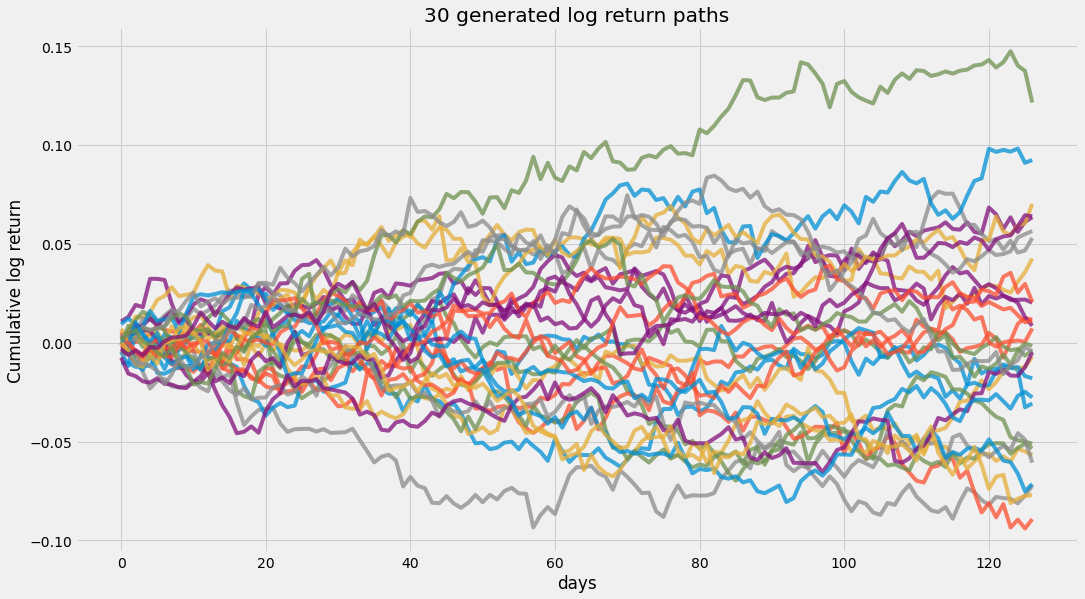

In [23]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.cumsum(y[0:30], axis=1).T, alpha=0.75)
ax.set_title('30 generated log return paths'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumulative log return');

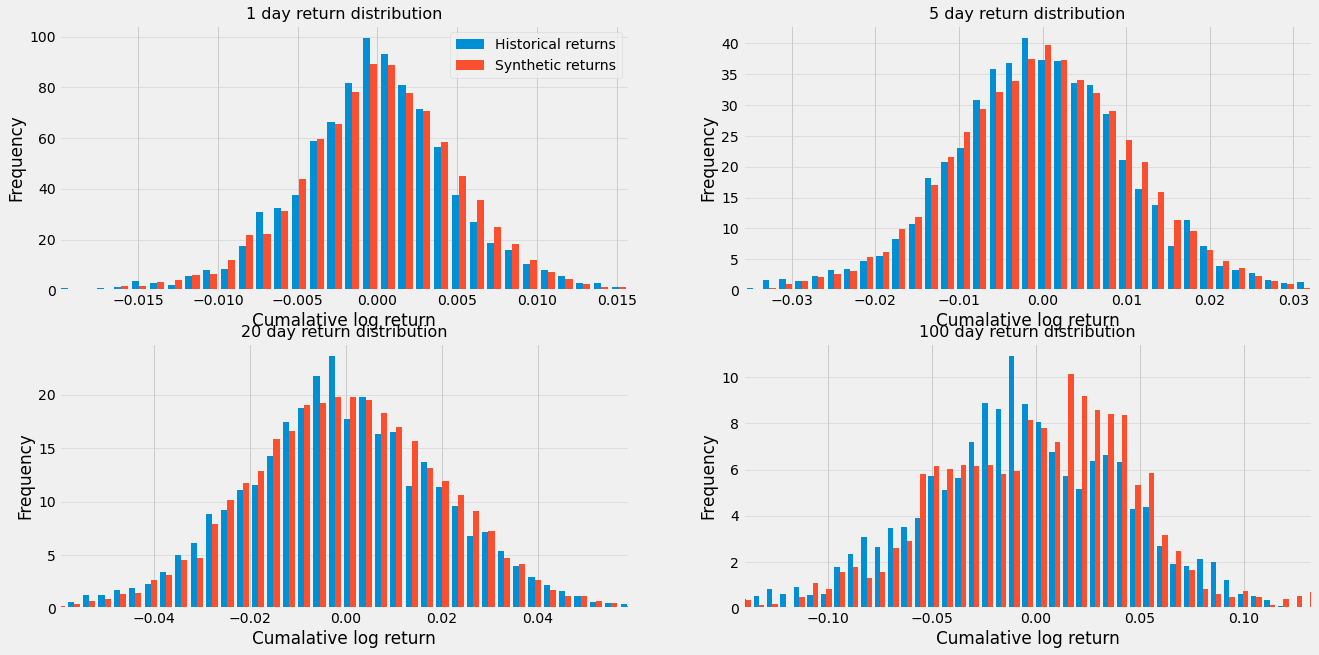

In [24]:
n_bins = 50
windows = [1, 5, 20, 100]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))


for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    col = i % 2
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    axs[row, col].hist(np.array([real_dist, fake_dist], dtype='object'), bins=50, density=True)
    axs[row,col].set_xlim(*np.quantile(fake_dist, [0.001, .999]))
    
    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=16)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].set_xlabel('Cumalative log return')
    axs[row,col].set_ylabel('Frequency')

axs[0,0].legend(['Historical returns', 'Synthetic returns'])

[Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days')]

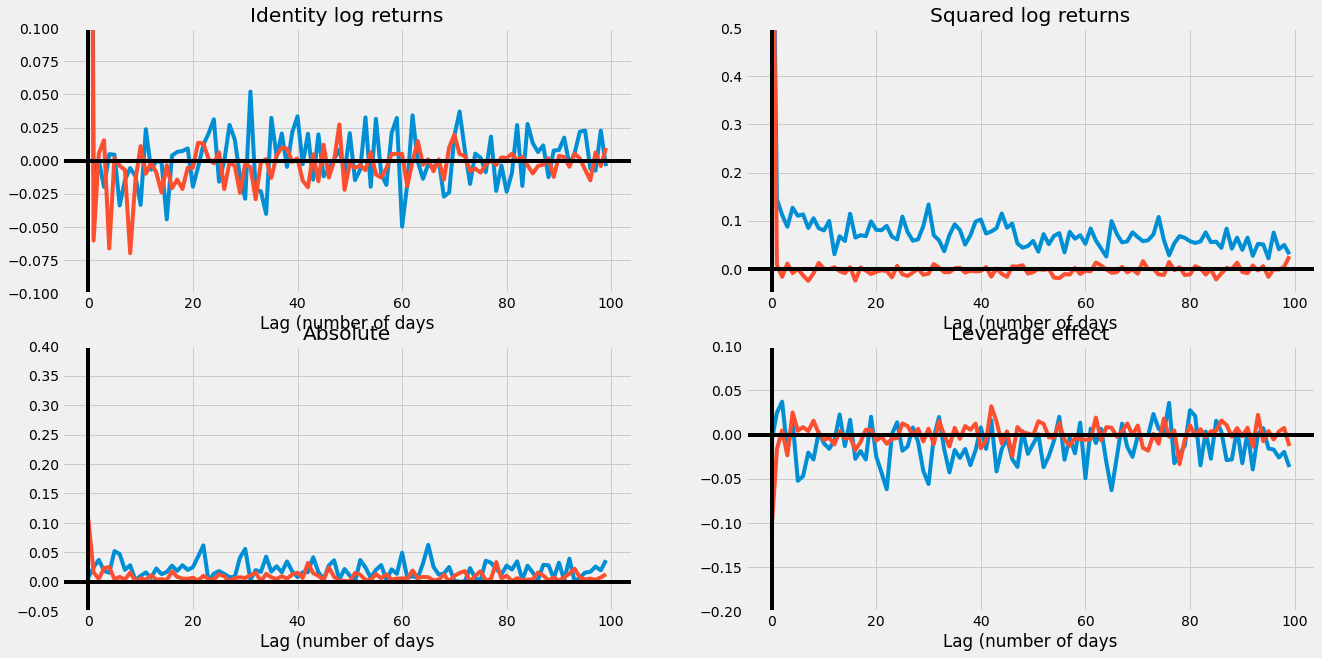

In [25]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

axs[0,0].plot(acf(log_returns, 100))
axs[0,0].plot(acf(y.T, 100).mean(axis=1))
axs[0,0].set_ylim(-0.1, 0.1)
axs[0,0].set_title('Identity log returns')
axs[0,1].plot(acf(log_returns**2, 100))
axs[0,1].set_ylim(-0.05, 0.5)
axs[0,1].plot(acf(y.T**2, 100).mean(axis=1))
axs[0,1].set_title('Squared log returns')
axs[1,0].plot(abs(acf(log_returns, 100, le=True)))
axs[1,0].plot(abs(acf(y.T, 100, le=True).mean(axis=1)))
axs[1,0].set_ylim(-0.05, 0.4)
axs[1,0].set_title('Absolute')
axs[1,1].plot(acf(log_returns, 100, le=True))
axs[1,1].plot(acf(y.T, 100, le=True).mean(axis=1))
axs[1,1].set_ylim(-0.2, 0.1)
axs[1,1].set_title('Leverage effect')


for ax in axs.flat: 
  ax.grid(True)
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
plt.setp(axs, xlabel='Lag (number of days')

###### Play

In [53]:
df = pd.DataFrame(index=['a', 'b', 'c'], data=[range(2, 3), range(3, 4), range(5, 6)])

In [54]:
df

,0
a,2
b,3
c,5


In [56]:
(df > 0).all()

0    True
dtype: bool